In [1]:
!pip install langchain langgraph langchain-huggingface langchain-ollama langchain-openai langchain-community
!pip install pinecone sentence-transformers pymupdf serpapi google-search-results openapi pyarrow fastparquet

In [2]:
pip install gradio

In [3]:
import fitz  # PyMuPDF for PDF processing
from datetime import datetime
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.memory import ConversationBufferMemory
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from pinecone import Pinecone
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools import Tool
from sentence_transformers import CrossEncoder, SentenceTransformer
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from langchain.utilities import SerpAPIWrapper
from langchain_core.messages import SystemMessage, HumanMessage
from typing import TypedDict
import pandas as pd
import os

In [4]:
# Fetch folders from google drive into the current session
# !pip install gdown
# !gdown --folder https://drive.google.com/drive/folders/1E4LtM210hm0wTNm7sYJUCZsk9l0TTytV?usp=sharing

# folder_path = "/content/data/"

from google.colab import drive
drive.mount('/content/drive')

folder_path = "/content/drive/My Drive/GenAI/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.environ["SERPAPI_API_KEY"] = <SERPAPI_API_KEY>
os.environ['PINECONE_API_KEY'] = <PINECONE_API_KEY>
os.environ["OPENAI_API_KEY"] = <OPENAI_API_KEY>

# Setup vector database
pinecone_api_key = os.getenv("PINECONE_API_KEY")

pc = Pinecone(api_key=pinecone_api_key)
index_name = "profilestore"
index = pc.Index(index_name)

embedder = HuggingFaceEmbeddings(model_name = 'BAAI/bge-base-en-v1.5')

# Conversation history
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# SerpAPI
serpapi_tools = SerpAPIWrapper(serpapi_api_key=os.getenv("SERPAPI_API_KEY"))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-5-6b17b6ba41e4>:15: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)


In [6]:
# OpenAI
import openai
from langchain_openai import ChatOpenAI,OpenAI

openai.api_key = os.getenv("OPENAI_API_KEY")
openaillm = ChatOpenAI(model = "gpt-4-turbo", temperature=0.5)


In [7]:
pip install langchain_experimental

In [8]:
from langchain_experimental.tools import PythonREPLTool

current_year = datetime.now().year


python_repl = PythonREPLTool()
math_tool = Tool(name="Python REPL", func=python_repl.run, description="Useful for executing math operations")

def serapi_search(query):
    return serpapi_tools.run(query)

fraud_tool = Tool(
    name = "SerpAPI_Search",
    func = serapi_search,
    description = "latest banking fraud detection site:fincen.gov OR site:fbi.gov OR site:forbes.com OR site:bloomberg.com"
)

financial_tool = Tool(
    name = "SerpAPI_Search",
    func = serapi_search,
    description = f"latest financial fraud trends {current_year} OR money laundering techniques {current_year}"
)

tools = [fraud_tool,financial_tool, math_tool]
openaillm.bind_tools(tools)

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7d9111364ed0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7d91117a4250>, root_client=<openai.OpenAI object at 0x7d911179ff10>, root_async_client=<openai.AsyncOpenAI object at 0x7d91117a6d50>, model_name='gpt-4-turbo', temperature=0.5, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'SerpAPI_Search', 'description': 'latest banking fraud detection site:fincen.gov OR site:fbi.gov OR site:forbes.com OR site:bloomberg.com', 'parameters': {'properties': {'__arg1': {'title': '__arg1', 'type': 'string'}}, 'required': ['__arg1'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'SerpAPI_Search', 'description': 'latest financial fraud trends 2025 OR money laundering techniques 2025', 'parameters': {'properties': {'__arg1': {'title': '__arg1', 'type': 'string'

In [9]:
from sklearn.ensemble import IsolationForest
import joblib

class ModelParams(BaseModel):
    gender: str = Field()
    amt: int = Field()
    unix_time: int = Field()
    category: str = Field()
    merchant: str = Field()
    city_pop: int = Field()

model_parser = PydanticOutputParser(pydantic_object=ModelParams)

def fraud_detection_check(query):
    print("Query output " + str(query))
    # Load model
    model = joblib.load(folder_path + 'unsupervised learning/isolation_forest_model.joblib')
    features = ["gender", "amt", "unix_time", "category", "merchant", "city_pop"]

    # ✅ Check model type
    if not isinstance(model, IsolationForest):
        raise TypeError(f"Expected IsolationForest model, but got {type(model)}")

    print("Query is " + str(query))
    query["unix_time"] = datetime.strptime(query["unix_time"], "%Y-%m-%d %H:%M:%S").timestamp()

    new_transaction = pd.DataFrame([query])
    new_transaction_encoded = pd.get_dummies(new_transaction)

    df = pd.read_parquet(folder_path + "unsupervised learning/dataset.parquet")

    # Ensure all columns match the training dataset
    df_selected = pd.get_dummies(df[features])
    missing_cols = set(df_selected.columns) - set(new_transaction_encoded.columns)

    missing_df = pd.DataFrame(0, index=new_transaction_encoded.index, columns=list(missing_cols))
    new_transaction_encoded = pd.concat([new_transaction_encoded, missing_df], axis=1)

    # Reorder columns to match training data
    new_transaction_encoded = new_transaction_encoded[df_selected.columns]

    # Predict fraud score (-1 = fraud, 1 = normal)
    fraud_score = model.predict(new_transaction_encoded)[0]

    # Convert to readable format
    fraud_detected = 1 if fraud_score == -1 else 0

    return fraud_detected

In [10]:
# Test Fraud
date_str = "2024-03-23 00:30:00"
unix = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S").timestamp()

fraud_detection_check({
  "gender": "F",
  "amt": 300,
  "unix_time": "2024-03-23 14:30:00",
  "category": "Transaction",
  "merchant": "Small Buisness",
  "city_pop": 500000000000
})

Query output {'gender': 'F', 'amt': 300, 'unix_time': '2024-03-23 14:30:00', 'category': 'Transaction', 'merchant': 'Small Buisness', 'city_pop': 500000000000}
Query is {'gender': 'F', 'amt': 300, 'unix_time': '2024-03-23 14:30:00', 'category': 'Transaction', 'merchant': 'Small Buisness', 'city_pop': 500000000000}


0

In [11]:
# RISK ANALYSIS GRAPH

class RiskAnalysisState(TypedDict):
    messages: list[dict[str, str]]
    query: dict
    rules: str
    risk_score: float

def reasoner(state: RiskAnalysisState):
    print("Reasoner " + str(state))
    user_query = state.get("query", "")
    rules = state.get("rules", "")

    # Chain-of-Thought Reasoning Prompt
    context_prompt = f"""
    You are a compliance risk evaluator. Follow this step-by-step approach to validate the financial profile:
    Keep your output a bit small

    1. **Extract Key Details**: Identify major financial transactions, loan history, and unusual activity.
    2. **Compare with Policy Rules**: Use the provided policy guidelines to check for violations.
    3. **Assess Risk Score**: Assign a risk score (0-1).
    4. **Explain the Decision**: Provide justification for the assigned risk score.
    User Request:
    {user_query}

    Regulatory Rules:
    {rules}
    """

    message = [{"role": "system", "content": context_prompt}]
    response = openaillm.invoke(message + state["messages"])

    print("Reasoner response", response)

    risk_score = extract_risk_score(response.content)
    updated_risk_score = risk_score if risk_score is not None else state.get("risk_score", 0)

    return {"messages": state["messages"] + [response], "risk_score": updated_risk_score }

In [12]:
import re

def extract_risk_score(response_text):
    match = re.search(r"\*\*?Risk Score\*\*?:?\s*([\d.]+)", response_text)
    return float(match.group(1)) if match else None

def decision_node(state: RiskAnalysisState) -> str:
    human_review_required = state.get("risk_score", 0) > 0.7
    return "human_review" if human_review_required else "low_risk_message"

def human_review(state: RiskAnalysisState):
    last_message = state["messages"][-1]["content"]
    risk_score = extract_risk_score(last_message)

    # 🚨 If the risk score is high, pause for human review
    if risk_score >= 0.7:
        msg = "🚨 High-Risk Alert! Manual review required."
        return {"messages": [{"role": "assistant", "content": msg }]}

    return {"messages": state["messages"]}

In [29]:
def evaluate_risk(state: RiskAnalysisState):
    print("risk  " + str(state))
    user_query = state.get("query", "")
    risk_score = state.get("risk_score", "")

    print("Risk score before evaluation", risk_score)

    is_fraud = fraud_detection_check(user_query)

    print("Is fraudulent?", is_fraud)

    final_risk_score = is_fraud * 0.5 + risk_score * 0.5

    print("Risk score after evaluation", final_risk_score)

    response = openaillm.invoke(f"""
      The Unsupervised Isolated Model has given a risk score of {str(is_fraud)}
      The risk score is either 0 or 1 only
    """)

    return {"messages": [response] + state["messages"],"risk_score": final_risk_score}

In [14]:
import json

def low_risk_message(state: RiskAnalysisState):
    assistant_response = [msg.content for msg in state["messages"]]
    rules = state.get("rules", "")
    risk = state.get("risk_score","")

    # ✅ Structured reasoning for final decision
    final_low_risk_prompt = ChatPromptTemplate([
    ("system", "You are a compliance analyst reviewing financial transactions for compliance assessment."),
    ("system", "This is an analytical tool for risk assessment insights. It does not make final financial decisions.")  ,
    ("user", f"**Policy Context Retrieved**:\n{rules}"),
    ("user", f"**Previous Analysis**:\n{assistant_response}"),
    ("user", f"**Generate a structured response including a risk score, key analysis points, and recommendations. The updated risk score is calculated as: ml_model_risk_score * 0.5 + llm_risk_score * 0.5, which results in {risk}. Keep the response clear and relevant to compliance without including personally identifiable details.**"),
    ("system",f"** Generate an analysis or remedial action that can take place to reduce the profile rizk. Do not include an sensitive terms")
    ])


    # ✅ Let LLM generate the final structured response
    final_response = openaillm.invoke(final_low_risk_prompt.format_prompt().to_messages() + state["messages"])

    return {"messages": [{"role": "assistant", "content": final_response.content}]}

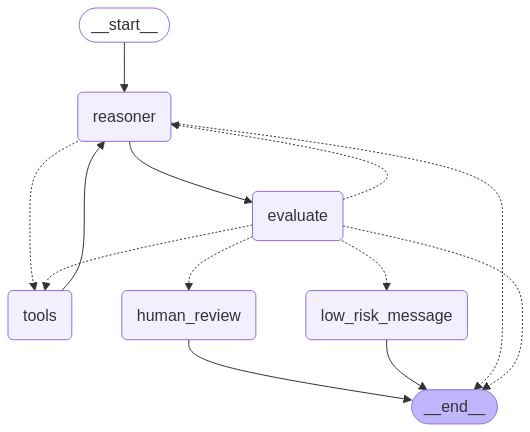

In [30]:
builder = StateGraph(RiskAnalysisState)

builder.add_node("reasoner",reasoner)
builder.add_node("tools",ToolNode(tools))
builder.add_node("evaluate", evaluate_risk)
builder.add_node("human_review", human_review)
builder.add_node("low_risk_message", low_risk_message)

builder.add_edge(START,"reasoner")
builder.add_conditional_edges("reasoner",tools_condition)
builder.add_edge("tools","reasoner")
builder.add_edge("reasoner","evaluate")
builder.add_conditional_edges("evaluate", decision_node)

builder.add_edge("human_review", END)
builder.add_edge("low_risk_message", END)

validate_graph = builder.compile()


validate_graph

In [31]:
date_str = "2024-03-23 00:30:00"
unix = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S").timestamp()

query = {
  "gender": "M",
  "amt": 500,
  "unix_time": "2024-03-23 00:30:00",
  "category": "From Software",
  "merchant": "Amazon",
  "city_pop": 5000000000
}

rules = """
*Schedule A - Retail Determination Process*

1. *Data Collection*
   - Sources: Utilizes credit reports, consumer panels, internal systems for retail banking data accuracy.
   - Importance: Ensures reliable data for comprehensive analysis.

2. *Credit Quality Analysis*
   - Metrics: Calculates delinquency rates at 30, 60, and 90 days to assess risk levels in different loan segments (credit card accounts, installment loans).

3. *Trend Analysis*
   - Comparison: Analyzes performance across various consumer segments to track changes over time.

4. *Delinquency Rate Calculation*
   - Percentage Determination: Identifies the proportion of delinquent borrowers contributing to credit risk assessment.
|
5. *Credit Utilization Metrics*
   - Ratio Assessment: Evaluates average credit utilization, indicating consumer leverage and future default risk potential.

6. *Risk-Weighted Asset (RWA) Calculation*
   - Risk Assessment: Measures the riskiness of assets against regulatory requirements for capital adequacy.

7. *Stress Testing*
   - Scenario Simulation: Assesses potential impacts on credit performance under adverse economic conditions to ensure solvency.

8. *Liquidity Assessment*
   - Liquidity Monitoring: Evaluates the bank's ability to meet short-term obligations using retail deposits and liquid assets.

9. *Regulatory Compliance*
   - Standards Adherence: Ensures data consistency with GAAP and Basel III regulations for accurate reporting.

10. *Reporting & Analysis*
    - Comprehensive Reporting: Presents detailed insights into credit performance, trends, risk metrics, and regulatory compliance status to support strategic decision-making in product development, risk management, and marketing strategies.
"""


In [32]:
def chatbot(query,rules):
    requestObj = {"query": query, "rules": rules, "messages": []}
    response = validate_graph.invoke(requestObj)
chatbot(query,rules)


Reasoner {'messages': [], 'query': {'gender': 'M', 'amt': 500, 'unix_time': '2024-03-23 00:30:00', 'category': 'From Software', 'merchant': 'Amazon', 'city_pop': 5000000000}, 'rules': "\n*Schedule A - Retail Determination Process*\n\n1. *Data Collection*\n   - Sources: Utilizes credit reports, consumer panels, internal systems for retail banking data accuracy.\n   - Importance: Ensures reliable data for comprehensive analysis.\n\n2. *Credit Quality Analysis*\n   - Metrics: Calculates delinquency rates at 30, 60, and 90 days to assess risk levels in different loan segments (credit card accounts, installment loans).\n\n3. *Trend Analysis*\n   - Comparison: Analyzes performance across various consumer segments to track changes over time.\n\n4. *Delinquency Rate Calculation*\n   - Percentage Determination: Identifies the proportion of delinquent borrowers contributing to credit risk assessment.\n|\n5. *Credit Utilization Metrics*\n   - Ratio Assessment: Evaluates average credit utilization

In [ ]:
import gradio as gr
import json

def process_input1(user_input):
    """Processes JSON input and stores it."""
    try:
        parsed_dict = json.loads(user_input)  # Convert JSON string to dictionary
        processed_data = parsed_dict

        return [("User", user_input), ("Bot", f"✅ Successfully processed JSON: {processed_data}")], processed_data
    except json.JSONDecodeError:
        return [("Bot", "❌ Invalid JSON format. Please enter a valid JSON.")], None

def process_final(processed_input1, input2):
    """Combines stored JSON data with second input."""
    if processed_input1 is None:
        return [("Bot", "❌ No valid JSON processed. Please start again.")]

    requestObj = {"query": processed_input1, "rules": input2, "messages": []}
    response = validate_graph.invoke(requestObj)

    return [("User", input2), ("Bot", response["messages"][-1]["content"])]

with gr.Blocks() as demo:
    gr.Markdown("# 🤖 AI Chatbot\nWelcome! Enter your inputs below.")

    chatbot = gr.Chatbot(label="Chat")  # Chat-style component
    state = gr.State()  # Store processed JSON

    with gr.Row():
        input1 = gr.Textbox(label="Enter a transaction profile as a JSON please")
        btn1 = gr.Button("Submit Transaction ")

    btn1.click(process_input1, inputs=input1, outputs=[chatbot, state])

    with gr.Row(visible=False) as second_input_row:
        input2 = gr.Textbox(label="Add the Regulatory Rules to validate the Profile")
        btn2 = gr.Button("Generate Analysis")

    btn1.click(lambda: gr.update(visible=True), outputs=second_input_row)
    btn2.click(process_final, inputs=[state, input2], outputs=chatbot)

demo.launch(debug=True)


<ipython-input-33-c6add50967f3>:27: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Chat")  # Chat-style component


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ce7141da9d3a616e2e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Reasoner {'messages': [], 'query': {'gender': 'M', 'amt': 500, 'unix_time': '2024-03-23 00:30:00', 'category': 'From Software', 'merchant': 'Amazon', 'city_pop': 5000000000}, 'rules': "*Schedule A - Retail Determination Process*\n\n1. *Data Collection*\n   - Sources: Utilizes credit reports, consumer panels, internal systems for retail banking data accuracy.\n   - Importance: Ensures reliable data for comprehensive analysis.\n\n2. *Credit Quality Analysis*\n   - Metrics: Calculates delinquency rates at 30, 60, and 90 days to assess risk levels in different loan segments (credit card accounts, installment loans).\n\n3. *Trend Analysis*\n   - Comparison: Analyzes performance across various consumer segments to track changes over time.\n\n4. *Delinquency Rate Calculation*\n   - Percentage Determination: Identifies the proportion of delinquent borrowers contributing to credit risk assessment.\n|\n5. *Credit Utilization Metrics*\n   - Ratio Assessment: Evaluates average credit utilization, 

In [ ]:
openaillm.invoke("hello")